# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import wiggum as wg
import mlsim as spdata
from mlsim import sp_plot
import itertools as itert

First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,9.888748,11.688020,12.514367,13.367864,11.920862,14.068670,A2,B0,C4
1,11.190462,16.439334,12.616934,7.804421,11.133880,10.522566,A1,B1,C0
2,11.605290,10.529006,10.664509,9.296602,13.022891,12.912704,A2,B1,C0
3,14.806380,12.280797,12.043132,14.421059,12.878602,13.416066,A1,B0,C4
4,12.822383,9.509439,13.036384,12.525300,7.451352,11.642583,A2,B0,C3


We'll also plot them in the dimensions where we added SP

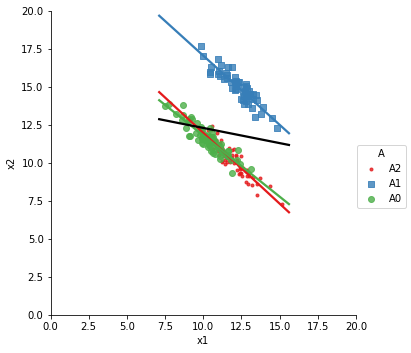

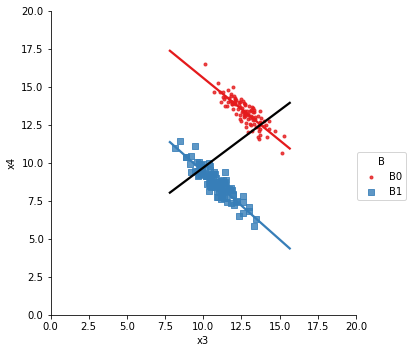

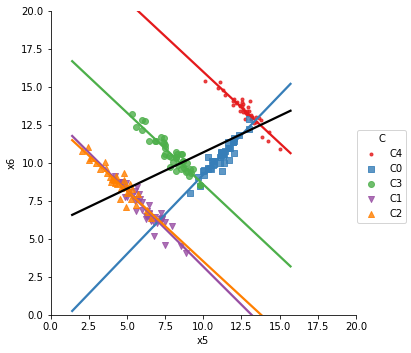

In [3]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_allTrend = wg.mark_designed_rows(wg.get_subgroup_Trends_1lev(many_sp_df_diff,['pearson_corr']),sp_design_list)
many_sp_df_diff_allTrend.head() # we only need to see a little

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed
0,x1,x2,-0.908312,A,A0,pearson_corr,-0.125146,True
1,x1,x2,-0.910344,A,A1,pearson_corr,-0.125146,True
2,x1,x2,-0.923931,A,A2,pearson_corr,-0.125146,True
3,x1,x2,-0.013876,B,B0,pearson_corr,-0.125146,False
4,x1,x2,-0.222435,B,B1,pearson_corr,-0.125146,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_allTrend['designed'].value_counts()

False    140
True      10
Name: designed, dtype: int64

We can look at the correlation coefficients of the SP detections first

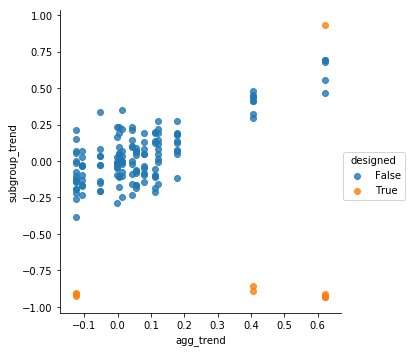

In [6]:

sns.lmplot('agg_Trend','subgroup_Trend',data=many_sp_df_diff_allTrend, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_allTrend.groupby('designed')['agg_Trend'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,140.0,0.062337,0.165624,-0.125146,-0.051178,0.044843,0.112540,0.622508
True,10.0,0.354793,0.342297,-0.125146,0.007494,0.513962,0.622508,0.622508


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module that compute the slopes of each subgroup Trend and the overall Trend lines. Here we will start to work with the full set of all Trends

In [8]:
results_df_slopes = wg.add_slope_cols(many_sp_df_diff, many_sp_df_diff_allTrend)

results_df_slopes.head()

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope
0,x1,x2,-0.908312,A,A0,pearson_corr,-0.125146,True,-0.804243,-0.199438
1,x1,x2,-0.910344,A,A1,pearson_corr,-0.125146,True,-0.909950,-0.199438
2,x1,x2,-0.923931,A,A2,pearson_corr,-0.125146,True,-0.930291,-0.199438
3,x1,x2,-0.013876,B,B0,pearson_corr,-0.125146,False,-0.019934,-0.199438
4,x1,x2,-0.222435,B,B1,pearson_corr,-0.125146,False,-0.388203,-0.199438


For ranking, looking at the angle between is most interesting

In [9]:

results_df_slopes = wg.add_angle_col(results_df_slopes)
results_df_slopes.head()

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
0,x1,x2,-0.908312,A,A0,pearson_corr,-0.125146,True,-0.804243,-0.199438,27.528777
1,x1,x2,-0.910344,A,A1,pearson_corr,-0.125146,True,-0.909950,-0.199438,31.021638
2,x1,x2,-0.923931,A,A2,pearson_corr,-0.125146,True,-0.930291,-0.199438,31.652803
3,x1,x2,-0.013876,B,B0,pearson_corr,-0.125146,False,-0.019934,-0.199438,10.136966
4,x1,x2,-0.222435,B,B1,pearson_corr,-0.125146,False,-0.388203,-0.199438,9.937362


Next, we can plot these and sanity check the angle computations

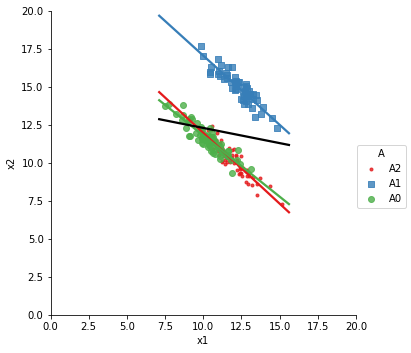

In [10]:
sp_plot(many_sp_df_diff,'x1','x2','A')

In [11]:
cur_row = wg.get_Trend_row(results_df_slopes, 'x1','x2','A2')
cur_row

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
2,x1,x2,-0.923931,A,A2,pearson_corr,-0.125146,True,-0.930291,-0.199438,31.652803


([array([0.55244563]), array([0.55244563])],)

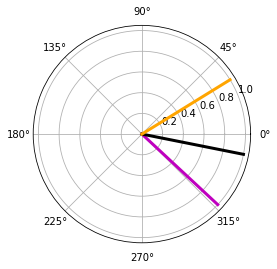

In [12]:
ax = plt.subplot(111, projection='polar')

# np.arctan(cur_row['subgroup_slope'].values)*2
ax.plot([np.arctan(cur_row['subgroup_slope'].values)]*2, [0,1],'m', linewidth=3)
ax.plot([np.arctan(cur_row['all_slope'].values)]*2, [0,1],'k', linewidth=3)
ax.plot([np.deg2rad(cur_row['angle'].values)]*2, [0,1],'orange', linewidth=3)
[np.deg2rad(cur_row['angle']).values]*2,

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
3,x1,x2,-0.013876,B,B0,pearson_corr,-0.125146,False,-0.019934,-0.199438,10.136966


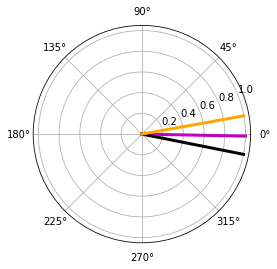

In [13]:
cur_row = wg.get_Trend_row(results_df_slopes, 'x1','x2','B0')

ax = plt.subplot(111, projection='polar')

# np.arctan(cur_row['subgroup_slope'].values)*2
ax.plot([np.arctan(cur_row['subgroup_slope'].values)]*2, [0,1],'m', linewidth=3)
ax.plot([np.arctan(cur_row['all_slope'].values)]*2, [0,1],'k', linewidth=3)
ax.plot([np.deg2rad(cur_row['angle'].values)]*2, [0,1],'orange', linewidth=3)
cur_row

In [14]:
np.rad2deg(np.arctan(cur_row['all_slope']))

3   -11.278976
Name: all_slope, dtype: float64

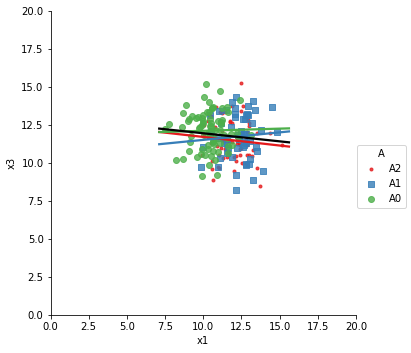

In [15]:
sp_plot(many_sp_df_diff,'x1','x3','A',ax=ax)

In [16]:
cur_row = wg.get_Trend_row(results_df_slopes, 'x1','x3','A0')
cur_row

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
10,x1,x3,0.023782,A,A0,pearson_corr,-0.105682,False,0.028581,-0.10622,7.700318


([array([0.13439591]), array([0.13439591])],)

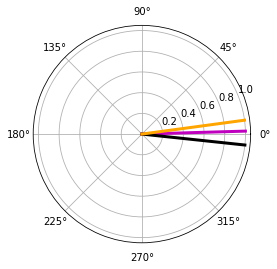

In [17]:
ax = plt.subplot(111, projection='polar')

# np.arctan(cur_row['subgroup_slope'].values)*2
ax.plot([np.arctan(cur_row['subgroup_slope'].values)]*2, [0,1],'m', linewidth=3)
ax.plot([np.arctan(cur_row['all_slope'].values)]*2, [0,1],'k', linewidth=3)
ax.plot([np.deg2rad(cur_row['angle'].values)]*2, [0,1],'orange', linewidth=3)
[np.deg2rad(cur_row['angle']).values]*2,

In [18]:
np.rad2deg(np.arctan(cur_row['subgroup_slope']))

10    1.63711
Name: subgroup_slope, dtype: float64

In [19]:
# check the slop computation
row = cur_row
data_df = many_sp_df_diff

# data_rows = data_df.loc[data_df[row['group_feat']]==row['subgroup']]
# feat1data = data_rows[row['feat1']]
# feat2data = data_rows[row['feat2']]
# data_rows.head()
data_df[(data_df[row['group_feat']] ==row['subgroup'].values).values].head()
# data_df.loc[data_keep_rows.values]
# row['subgroup'].values


,x1,x2,x3,x4,x5,x6,A,B,C
5,9.892788,12.200873,9.166184,9.927772,7.947192,5.823306,A0,B1,C1
7,11.182591,11.254073,12.587355,14.097001,4.693816,8.401403,A0,B0,C1
8,10.617852,10.630625,13.660831,11.584829,7.872393,10.352202,A0,B0,C3
11,10.328222,11.034522,11.143216,8.185689,7.513529,10.553542,A0,B1,C3
12,10.399389,11.701511,13.321152,13.497623,5.681238,8.423526,A0,B0,C1


Then, to rank, we can sort by various values

In [20]:
results_df_slopes.sort_values('angle',ascending=False).head(10)

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
94,x3,x4,-0.891899,B,B1,pearson_corr,0.405416,True,-0.891397,0.752461,78.673757
93,x3,x4,-0.854927,B,B0,pearson_corr,0.405416,True,-0.819281,0.752461,76.287138
146,x5,x6,-0.915038,C,C1,pearson_corr,0.622508,True,-1.001370,0.479306,70.647906
148,x5,x6,-0.933559,C,C3,pearson_corr,0.622508,True,-0.944201,0.479306,68.964716
149,x5,x6,-0.936577,C,C4,pearson_corr,0.622508,True,-0.936751,0.479306,68.738229
147,x5,x6,-0.928464,C,C2,pearson_corr,0.622508,True,-0.928647,0.479306,68.489907
61,x2,x4,-0.288090,A,A1,pearson_corr,-0.002278,False,-0.668644,-0.002666,33.615684
2,x1,x2,-0.923931,A,A2,pearson_corr,-0.125146,True,-0.930291,-0.199438,31.652803
1,x1,x2,-0.910344,A,A1,pearson_corr,-0.125146,True,-0.909950,-0.199438,31.021638
21,x1,x4,0.234583,A,A1,pearson_corr,0.004028,False,0.544220,0.007514,28.125370


In [21]:
results_df_slopes.sort_values('agg_Trend',ascending=False).head(10)

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,all_slope,angle
149,x5,x6,-0.936577,C,C4,pearson_corr,0.622508,True,-0.936751,0.479306,68.738229
144,x5,x6,0.555581,B,B1,pearson_corr,0.622508,False,0.425145,0.479306,2.576142
141,x5,x6,0.464924,A,A1,pearson_corr,0.622508,False,0.343650,0.479306,6.643422
142,x5,x6,0.695063,A,A2,pearson_corr,0.622508,False,0.525304,0.479306,2.104456
143,x5,x6,0.679647,B,B0,pearson_corr,0.622508,False,0.517715,0.479306,1.762603
140,x5,x6,0.695280,A,A0,pearson_corr,0.622508,False,0.557667,0.479306,3.538272
145,x5,x6,0.930401,C,C0,pearson_corr,0.622508,True,1.045012,0.479306,20.652241
147,x5,x6,-0.928464,C,C2,pearson_corr,0.622508,True,-0.928647,0.479306,68.489907
148,x5,x6,-0.933559,C,C3,pearson_corr,0.622508,True,-0.944201,0.479306,68.964716
146,x5,x6,-0.915038,C,C1,pearson_corr,0.622508,True,-1.001370,0.479306,70.647906


We can also compare how each occurence ranks by different variables. 

In [22]:
results_df_slopes.rank(numeric_only=True).head(10)

,subgroup_Trend,agg_Trend,designed,subgroup_slope,all_slope,angle
0,7.0,5.5,145.5,9.0,5.5,139.0
1,6.0,5.5,145.5,6.0,5.5,142.0
2,4.0,5.5,145.5,4.0,5.5,143.0
3,71.0,5.5,70.5,70.0,5.5,96.0
4,16.0,5.5,70.5,15.0,5.5,95.0
5,36.0,5.5,70.5,23.0,5.5,10.0
6,20.0,5.5,70.5,18.0,5.5,55.0
7,116.0,5.5,70.5,126.0,5.5,138.0
8,12.0,5.5,70.5,12.0,5.5,127.0
9,34.0,5.5,70.5,29.0,5.5,22.0


We can look at the spearman correlation of the various features.  THis is equic

In [23]:
results_df_slopes.corr(method='spearman')

,subgroup_Trend,agg_Trend,designed,subgroup_slope,all_slope,angle
subgroup_Trend,1.000000,0.390994,-0.345647,0.958359,0.393987,-0.323454
agg_Trend,0.390994,1.000000,0.160833,0.416474,0.978571,0.039057
designed,-0.345647,0.160833,1.000000,-0.346264,0.142276,0.423418
subgroup_slope,0.958359,0.416474,-0.346264,1.000000,0.428483,-0.334580
all_slope,0.393987,0.978571,0.142276,0.428483,1.000000,0.041195
angle,-0.323454,0.039057,0.423418,-0.334580,0.041195,1.000000


In [24]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,140.0,8.020686,6.695212,0.140116,2.608839,7.184041,11.598782,33.615684
True,10.0,54.265711,23.269613,20.652241,31.179429,68.614068,70.227108,78.673757


In [25]:
results_df_slopes.groupby('designed')['agg_Trend'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,140.0,0.062337,0.165624,-0.125146,-0.051178,0.044843,0.112540,0.622508
True,10.0,0.354793,0.342297,-0.125146,0.007494,0.513962,0.622508,0.622508


# View Ranking

For vizualization, we actually need to rank the views, where a view is defined by two attributes (to be used for x and y axes) and a colored view is defined by a triplet (attr1, attr2, groupby).

First, we'll look at the views , then different ways of ranking them. and finally ways to rank the occurences for highlighting within the view.  

The views show how many different plots of the data we would need to look at to see the SP occurences. 

In [26]:
wg.get_SP_views(results_df_slopes)

[('x1', 'x2'),
 ('x3', 'x6'),
 ('x5', 'x6'),
 ('x1', 'x4'),
 ('x3', 'x5'),
 ('x4', 'x5'),
 ('x3', 'x4'),
 ('x1', 'x6'),
 ('x4', 'x6'),
 ('x1', 'x3'),
 ('x2', 'x6'),
 ('x2', 'x3'),
 ('x2', 'x5'),
 ('x2', 'x4'),
 ('x1', 'x5')]

Colored views show how many different colorings we should plot to see the SP (colring the samples by groupby attribute and adding Trendlines for each color)

In [27]:
wg.get_SP_views(results_df_slopes,colored=True)

ValueError: too many values to unpack (expected 2)

To rank by views we need some sort of statistic for each of them.  First we will look at the number and portion of possible occurences for each view.  That is for how many groupby attributes does a view have SP or values of the groupby attribute does a colored view have SP, numerially and as a percentage in both cases

In [18]:
view_df = wg.count_sp_views(results_df_slopes)
view_df

,attr1,attr2,SP_subgroups
0,x1,x2,2
1,x1,x3,6
2,x1,x4,5
3,x1,x5,3
4,x1,x6,4
5,x2,x4,7


And we can also do this for colored views

In [19]:
colored=True

In [20]:
colored_view_df = wg.count_sp_views(results_df_slopes,colored= True)
colored_view_df.head()

,attr1,attr2,groupbyAttr,SP_subgroups
0,x1,x2,A,2
1,x1,x3,A,2
2,x1,x3,B,1
3,x1,x3,C,3
4,x1,x4,A,1


We can further look at the portion of the possible subgroups for colored views that have SP.  The poriton for non colored views is less meaningful, so we don't offer a means to compute it. This requires botht the results and the 
koriginal data, to get the number of possible levels. 

In [21]:
colored_view_df = wg.count_sp_views(results_df_slopes,colored= True,portions=True, data_df=many_sp_df_diff)
colored_view_df.head() 

,attr1,attr2,groupbyAttr,SP_subgroups,portions
0,x1,x2,A,2,0.666667
1,x1,x3,A,2,0.666667
2,x1,x3,B,1,0.500000
3,x1,x3,C,3,0.600000
4,x1,x4,A,1,0.333333


We can also add the number of total groupby attributes with SP per uncoloed view to a count df about either a colored or uncolored count.  We'll add it to the colored one, here

In [22]:
colored_view_df = wg.count_sp_views(results_df_slopes,colored= True,
                                     portions=True, data_df=many_sp_df_diff,
                                     groupby_count=True)
colored_view_df.head() 

,attr1,attr2,groupbyAttr,SP_subgroups,gby_counts,portions
0,x1,x2,A,2,1,0.666667
1,x1,x3,A,2,3,0.666667
2,x1,x3,B,1,3,0.500000
3,x1,x3,C,3,3,0.600000
4,x1,x4,A,1,3,0.333333


Finally, we can add these stats about the view to the dataframe of the occurences

In [23]:
result_df_views = wg.add_view_count(results_df_slopes,view_df)
result_df_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
0,0.783742,x1,x2,-0.911443,A,A0,True,-0.870104,0.416340,63.630557,2
1,0.783742,x1,x2,-0.918765,A,A1,True,-0.935041,0.416340,65.681212,2
2,0.026286,x1,x3,-0.038050,A,A0,False,-0.055577,0.007078,3.586630,6
3,0.026286,x1,x3,-0.141726,A,A2,False,-0.223322,0.007078,12.994396,6
4,0.026286,x1,x3,-0.166453,B,B0,False,-0.034361,0.007078,2.373497,6
5,0.026286,x1,x3,-0.002562,C,C0,False,-0.000682,0.007078,0.444632,6
6,0.026286,x1,x3,-0.057450,C,C1,False,-0.014197,0.007078,1.218959,6
7,0.026286,x1,x3,-0.023836,C,C3,False,-0.006097,0.007078,0.754880,6
8,-0.016606,x1,x5,0.087417,A,A0,False,0.478359,-0.017369,-26.559634,3
9,-0.016606,x1,x5,0.072004,C,C1,False,0.012844,-0.017369,-1.730979,3


In [24]:
result_df_colored_views = wg.add_view_count(results_df_slopes,colored_view_df ,colored=True)
result_df_colored_views.head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
0,0.783742,x1,x2,-0.911443,A,A0,True,-0.870104,0.416340,63.630557,2,1,0.666667
1,0.783742,x1,x2,-0.918765,A,A1,True,-0.935041,0.416340,65.681212,2,1,0.666667
2,0.026286,x1,x3,-0.038050,A,A0,False,-0.055577,0.007078,3.586630,2,3,0.666667
3,0.026286,x1,x3,-0.141726,A,A2,False,-0.223322,0.007078,12.994396,2,3,0.666667
4,0.026286,x1,x3,-0.166453,B,B0,False,-0.034361,0.007078,2.373497,1,3,0.500000
5,0.026286,x1,x3,-0.002562,C,C0,False,-0.000682,0.007078,0.444632,3,3,0.600000
6,0.026286,x1,x3,-0.057450,C,C1,False,-0.014197,0.007078,1.218959,3,3,0.600000
7,0.026286,x1,x3,-0.023836,C,C3,False,-0.006097,0.007078,0.754880,3,3,0.600000
8,-0.016606,x1,x5,0.087417,A,A0,False,0.478359,-0.017369,-26.559634,1,2,0.333333
9,-0.016606,x1,x5,0.072004,C,C1,False,0.012844,-0.017369,-1.730979,2,2,0.400000


Now we can sort and examine views based on these counts.

In [25]:
result_df_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups
13,0.004659,x2,x4,-0.142851,A,A2,False,-0.271525,0.002851,15.354352,7
15,0.004659,x2,x4,-0.128963,C,C0,False,-0.072380,0.002851,4.303251,7
17,0.004659,x2,x4,-0.027718,C,C2,False,-0.017109,0.002851,1.143561,7
11,0.004659,x2,x4,-0.032064,A,A0,False,-0.060724,0.002851,3.638322,7
12,0.004659,x2,x4,-0.057175,A,A1,False,-0.080160,0.002851,4.746389,7
16,0.004659,x2,x4,-0.006984,C,C1,False,-0.004413,0.002851,0.416205,7
14,0.004659,x2,x4,-0.190795,B,B0,False,-0.073983,0.002851,4.394562,7
2,0.026286,x1,x3,-0.038050,A,A0,False,-0.055577,0.007078,3.586630,6
3,0.026286,x1,x3,-0.141726,A,A2,False,-0.223322,0.007078,12.994396,6
4,0.026286,x1,x3,-0.166453,B,B0,False,-0.034361,0.007078,2.373497,6


In [26]:
result_df_colored_views.sort_values(by='SP_subgroups',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
13,0.004659,x2,x4,-0.142851,A,A2,False,-0.271525,0.002851,15.354352,3,3,1.0
11,0.004659,x2,x4,-0.032064,A,A0,False,-0.060724,0.002851,3.638322,3,3,1.0
25,0.024827,x1,x6,-0.005617,C,C3,False,-0.001029,0.011191,0.700135,3,2,0.6
24,0.024827,x1,x6,-0.069706,C,C0,False,-0.012138,0.011191,1.336624,3,2,0.6
22,-0.005211,x1,x4,0.060205,C,C4,False,0.019443,-0.001694,-1.210914,3,3,0.6
21,-0.005211,x1,x4,0.028458,C,C3,False,0.009555,-0.001694,-0.644523,3,3,0.6
20,-0.005211,x1,x4,0.074663,C,C2,False,0.026232,-0.001694,-1.599720,3,3,0.6
17,0.004659,x2,x4,-0.027718,C,C2,False,-0.017109,0.002851,1.143561,3,3,0.6
16,0.004659,x2,x4,-0.006984,C,C1,False,-0.004413,0.002851,0.416205,3,3,0.6
15,0.004659,x2,x4,-0.128963,C,C0,False,-0.072380,0.002851,4.303251,3,3,0.6


In [27]:
result_df_colored_views.sort_values(by='portions',ascending=False).head(10)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions
13,0.004659,x2,x4,-0.142851,A,A2,False,-0.271525,0.002851,15.354352,3,3,1.000000
11,0.004659,x2,x4,-0.032064,A,A0,False,-0.060724,0.002851,3.638322,3,3,1.000000
12,0.004659,x2,x4,-0.057175,A,A1,False,-0.080160,0.002851,4.746389,3,3,1.000000
1,0.783742,x1,x2,-0.918765,A,A1,True,-0.935041,0.416340,65.681212,2,1,0.666667
0,0.783742,x1,x2,-0.911443,A,A0,True,-0.870104,0.416340,63.630557,2,1,0.666667
3,0.026286,x1,x3,-0.141726,A,A2,False,-0.223322,0.007078,12.994396,2,3,0.666667
2,0.026286,x1,x3,-0.038050,A,A0,False,-0.055577,0.007078,3.586630,2,3,0.666667
5,0.026286,x1,x3,-0.002562,C,C0,False,-0.000682,0.007078,0.444632,3,3,0.600000
6,0.026286,x1,x3,-0.057450,C,C1,False,-0.014197,0.007078,1.218959,3,3,0.600000
25,0.024827,x1,x6,-0.005617,C,C3,False,-0.001029,0.011191,0.700135,3,2,0.600000


From this, we see that the colored views captures the designed cases and the portions captures them better, but the views alone does not. 

# Mixed Severity and View Ranking

We can create combined scores that include occurence severity stats(angle, correlation) and view count stats

In [28]:
std_weights = {'reverseCorr':.25,
              'angle':.25,
              'portions':.5}
mix_rank_std = wg.add_weighted(result_df_colored_views,std_weights,name='std_wt').sort_values(by='std_wt',ascending=False)
mix_rank_std

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle,SP_subgroups,gby_counts,portions,std_wt
13,0.004659,x2,x4,-0.142851,A,A2,False,-0.271525,0.002851,15.354352,3,3,1.000000,0.802245
11,0.004659,x2,x4,-0.032064,A,A0,False,-0.060724,0.002851,3.638322,3,3,1.000000,0.797427
12,0.004659,x2,x4,-0.057175,A,A1,False,-0.080160,0.002851,4.746389,3,3,1.000000,0.794325
3,0.026286,x1,x3,-0.141726,A,A2,False,-0.223322,0.007078,12.994396,2,3,0.666667,0.546123
2,0.026286,x1,x3,-0.038050,A,A0,False,-0.055577,0.007078,3.586630,2,3,0.666667,0.545831
20,-0.005211,x1,x4,0.074663,C,C2,False,0.026232,-0.001694,-1.599720,3,3,0.600000,0.509178
22,-0.005211,x1,x4,0.060205,C,C4,False,0.019443,-0.001694,-1.210914,3,3,0.600000,0.506717
21,-0.005211,x1,x4,0.028458,C,C3,False,0.009555,-0.001694,-0.644523,3,3,0.600000,0.500534
1,0.783742,x1,x2,-0.918765,A,A1,True,-0.935041,0.416340,65.681212,2,1,0.666667,0.500000
0,0.783742,x1,x2,-0.911443,A,A0,True,-0.870104,0.416340,63.630557,2,1,0.666667,0.496222


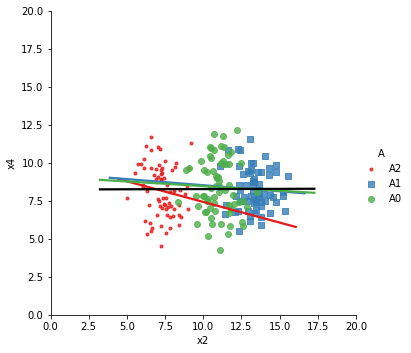

In [29]:
top_view = tuple(mix_rank_std[['attr1','attr2','groupbyAttr']].iloc[0])
sp_plot(many_sp_df_diff,*top_view)

THis ranks occurences, but we should also combine to rankthe views only, since that's what the actual figures will be. 

In [30]:

'_'.join([str(w) + c for c,w, in std_weights.items()])

'0.25reverseCorr_0.25angle_0.5portions'

In [31]:
list(std_weights.values())

[0.25, 0.25, 0.5]

In [32]:
result_df_colored_views[['angle','reverseCorr']] -result_df_colored_views[['angle','reverseCorr']].min()

,angle,reverseCorr
0,90.190191,0.007321
1,92.240846,0.000000
2,30.146264,0.880715
3,39.554030,0.777039
4,28.933131,0.752312
5,27.004266,0.916203
6,27.778593,0.861314
7,27.314514,0.894928
8,0.000000,1.006181
9,24.828655,0.990769


In [34]:
triu_indices = np.triu_indices(6)

In [40]:
many_sp_df_diff.groupby('A').corr().values[triu_indices]

array([ 1.        , -0.91144327, -0.03804985, -0.00511905,  0.0874166 ,
        0.01398681,  1.        , -0.0208826 , -0.03206368, -0.02717344,
       -0.03827242,  1.        ,  0.95013372, -0.02145923,  0.02615574,
        1.        , -0.03777319, -0.01615248,  1.        ,  0.53364709,
        1.        ])

In [41]:
many_sp_df_diff.corr().values[triu_indices]

array([ 1.        ,  0.78374205,  0.02628585, -0.00521072, -0.01660561,
        0.02482738,  1.        ,  0.04958495,  0.00465852,  0.05084829,
        0.08788898,  1.        ,  0.94125432,  0.06196953, -0.01526541,
        1.        ,  0.03304583, -0.05227218,  1.        ,  0.54343287,
        1.        ])

In [51]:
type(many_sp_df_diff.groupby('A')) is pd.core.groupby.groupby.DataFrameGroupBy

True

In [90]:
list(many_sp_df_diff.groupby('A').groups.keys())*num_vars

['A0',
 'A1',
 'A2',
 'A0',
 'A1',
 'A2',
 'A0',
 'A1',
 'A2',
 'A0',
 'A1',
 'A2',
 'A0',
 'A1',
 'A2',
 'A0',
 'A1',
 'A2']

In [85]:
data_df = many_sp_df_diff.groupby('A')
num_vars = 6
triu_indices_0 = np.triu_indices(num_vars,k=1)

    # append for all groups if groupby instead of single DataFrame
if type(data_df) is pd.core.groupby.groupby.DataFrameGroupBy:
    num_groups = len(data_df.groups)
    increments_x = [i*num_vars for i in range(num_groups)]*(len(triu_indices_0[0])) 
    triu_indices = (increments_x+ triu_indices_0[0].repeat(num_groups), triu_indices_0[1].repeat(num_groups))
else:
    triu_indices = triu_indices_0

data_df.corr().values[triu_indices]

array([-0.91144327, -0.91876459,  0.87260854, -0.03804985,  0.1021485 ,
       -0.14172604, -0.00511905,  0.06441711, -0.18155658,  0.0874166 ,
       -0.20632272, -0.09309685,  0.01398681, -0.24373277,  0.05914747,
       -0.0208826 , -0.08589643, -0.11603525, -0.03206368, -0.05717458,
       -0.14285133, -0.02717344,  0.22964487, -0.10821104, -0.03827242,
        0.27228626,  0.07576831,  0.95013372,  0.92089688,  0.94648139,
       -0.02145923,  0.12560469,  0.077771  ,  0.02615574, -0.05194033,
       -0.04973614, -0.03777319,  0.08510599,  0.05671318, -0.01615248,
       -0.09307998, -0.0715904 ,  0.53364709,  0.64796524,  0.4488938 ])

In [113]:
data_df.count().index.name

'A'

In [67]:
data_df.corr() #[triu_indices]

x1        x2        x3        x4        x5        x6
A                                                                
A0 x1  1.000000 -0.911443 -0.038050 -0.005119  0.087417  0.013987
   x2 -0.911443  1.000000 -0.020883 -0.032064 -0.027173 -0.038272
   x3 -0.038050 -0.020883  1.000000  0.950134 -0.021459  0.026156
   x4 -0.005119 -0.032064  0.950134  1.000000 -0.037773 -0.016152
   x5  0.087417 -0.027173 -0.021459 -0.037773  1.000000  0.533647
   x6  0.013987 -0.038272  0.026156 -0.016152  0.533647  1.000000
A1 x1  1.000000 -0.918765  0.102149  0.064417 -0.206323 -0.243733
   x2 -0.918765  1.000000 -0.085896 -0.057175  0.229645  0.272286
   x3  0.102149 -0.085896  1.000000  0.920897  0.125605 -0.051940
   x4  0.064417 -0.057175  0.920897  1.000000  0.085106 -0.093080
   x5 -0.206323  0.229645  0.125605  0.085106  1.000000  0.647965
   x6 -0.243733  0.272286 -0.051940 -0.093080  0.647965  1.000000
A2 x1  1.000000  0.872609 -0.141726 -0.181557 -0.093097  0.059147
   x2  0.872609  1.000000 -0.116035 -0.142851 -0.108211  0.075768
   x3 -0.141726 -0.116035  1.000000  0.946481  0.077771 -0.049736
   x4 -0.181557 -0.142851  0.946481  1.000000  0.056713 -0.071590
   x5 -0.093097 -0.108211  0.077771  0.056713  1.000000  0.448894
   x6  0.059147  0.075768 -0.049736 -0.071590  0.448894  1.000000

In [1]:
a, b = ['a','b']
a

'a'

In [22]:
results_df = many_sp_df_diff_allTrend
type='SP'
cols_pair = ['agg_Trend','subgroup_Trend']

In [23]:
SP_func = {'SP':lambda a,b: np.sign(a)==np.sign(b)}

# create column name
col_name = '_'.join(cols_pair) + '_' + type

col_a, col_b = cols_pair

sp_labeler = lambda row: SP_func[type](row[col_a],row[col_b])
results_df[col_name] = results_df.apply(sp_labeler,axis=1)

In [24]:
results_df.head()

,feat1,feat2,subgroup_Trend,group_feat,subgroup,Trend_type,agg_Trend,designed,subgroup_slope,agg_Trend_subgroup_Trend_SP
0,x1,x2,-0.866291,A,A0,pearson_corr,-0.314888,True,-0.877291,True
1,x1,x2,0.919110,A,A1,pearson_corr,-0.314888,True,0.976965,False
2,x1,x2,-0.929301,A,A2,pearson_corr,-0.314888,True,-0.944343,True
3,x1,x2,-0.222520,B,B0,pearson_corr,-0.314888,False,-0.134095,True
4,x1,x2,-0.396153,B,B1,pearson_corr,-0.314888,False,-0.230340,True


In [25]:
col_name in results_df.columns

True

In [26]:
sp_df = results_df[results_df[col_name] == True]

In [27]:
sp_df.shape

(97, 10)

In [28]:
results_df.shape

(150, 10)